In [1]:
import numpy as np
import os
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torch import nn, optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# print(torch.__version__)
# print(torchvision.__version__)
#torch==2.3.1+cu121
#matplotlib>=3.8.2
#torchvision==0.18.1+cu121
#numpy>=1.26.3
#tqdm>=4.66.2

2.3.1+cu121


NameError: name 'torchvision' is not defined

In [2]:
# from google.colab import drive

# drive.mount('/content/drive') # Colab authorization to access google drive

In [4]:
# Flowers path
FLOWER_PATH = r'<RELEVANT PATH>\102flowers\jpg' 
flowers_path = FLOWER_PATH
paths = [os.path.join(flowers_path, f) for f in os.listdir(flowers_path) if f.endswith('.jpg')]
print("Path:", flowers_path)
print("Files found:", paths)

# Randomizing dataset
np.random.seed(140)
paths_subset = np.random.choice(paths, 8189, replace=False) 
indices_perm = np.random.permutation(8189)

# Below we use a smaller dataset for different personal tests.
# train_idxs = indices_perm[:1000] # Allocating 80% of the dataset for the training.
# val_idxs = indices_perm[1000:1124] # Allocating 10% of the dataset for the validation.
# test_idxs = indices_perm[1124:1248] # Allocating 10% of the dataset for the test.

train_idxs = indices_perm[:6550] # Allocating 80% of the dataset for the training.
val_idxs = indices_perm[6550:7365] # Allocating 10% of the dataset for the validation.
test_idxs = indices_perm[7365:] # Allocating 10% of the dataset for the test.

# Creating paths using the allocated indices.
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
test_paths = paths_subset[test_idxs]

# Data allocation print.
print('Number of images allocated for each dataset:')
print('Train = ',len(train_paths), 'Validation = ', len(val_paths), 'Test = ', len(test_paths))

Path: G:\Downloads\102flowers\jpg
Files found: ['G:\\Downloads\\102flowers\\jpg\\image_00001.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00002.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00003.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00004.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00005.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00006.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00007.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00008.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00009.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00010.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00011.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00012.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00013.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00014.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00015.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00016.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00017.jpg', 'G:\\Downloads\\102flowers\\jpg\\image_00018.jpg', 'G:\\Downloads\\102flowers\\jpg\\i

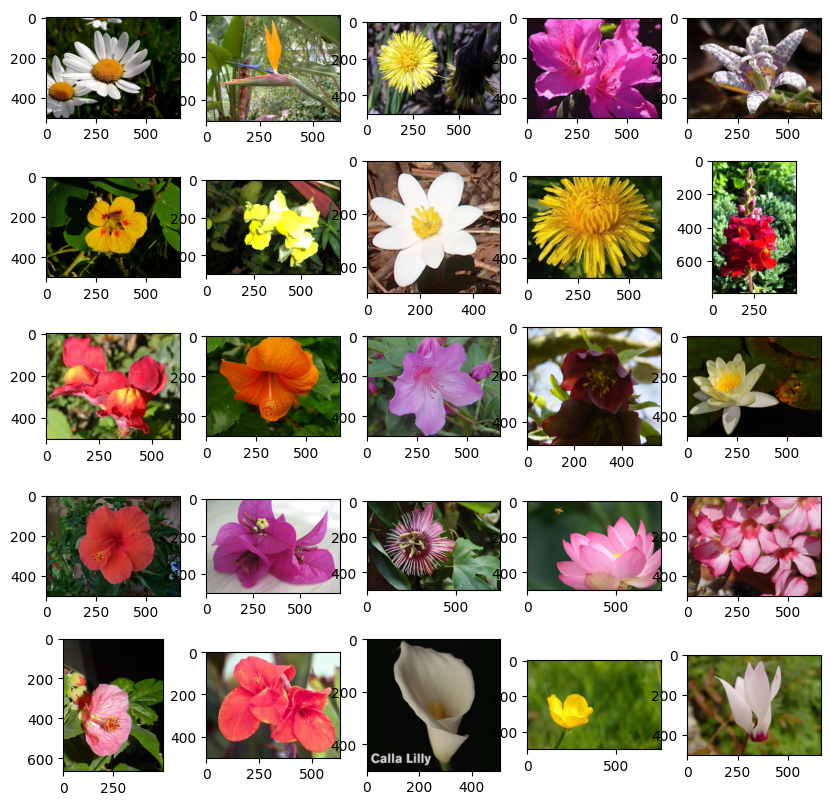

In [5]:
_, axes = plt.subplots(5, 5, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    img = Image.open(img_path)
    ax.imshow(img)

plt.show()
# Plot 25 images of flowers as an example.

In [6]:
res_shape = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, workset='train'):
        if workset == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((res_shape, res_shape),  Image.BICUBIC), transforms.RandomHorizontalFlip()]) # Flipping horizontally to create more variance
        elif (workset == 'validation') | (workset == 'test'):
            self.transforms = transforms.Resize((res_shape, res_shape),  Image.BICUBIC)
        # Definitions
        self.workset = workset
        self.size = res_shape
        self.paths = paths
    
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)

        img_lab = rgb2lab(img).astype("float32") # Convert to LAB
        img_lab = transforms.ToTensor()(img_lab)

        L = img_lab[[0], ...] / 50 - 1 
        ab = img_lab[[1, 2], ...] / 110 
        
        return {'L': L, 'ab': ab}
    
    
# Data loader.
def create_dataloader(batch_size=16, n_workers=0, pin_memory=True, **kwargs):
    colorization_dataset = ColorizationDataset(**kwargs)
    colorization_dataloader = DataLoader(colorization_dataset, batch_size=batch_size, num_workers=n_workers, pin_memory=pin_memory) 
    return colorization_dataloader

In [7]:
%matplotlib inline


test_dl = create_dataloader(paths=test_paths, workset='test')
val_dl = create_dataloader(paths=val_paths, workset='validation')
train_dl = create_dataloader(paths=train_paths, workset='train')


train_data = next(iter(train_dl))

l_data = train_data['L']
ab_data = train_data['ab']
print('L shape = ', l_data.shape, 'ab shape = ', ab_data.shape)

# Print dataloader batches.
print('Batches in dataloaders:')
print('Train = ', len(train_dl), 'Validation = ',len(val_dl), 'Test = ', len(test_dl))

L shape =  torch.Size([16, 1, 256, 256]) ab shape =  torch.Size([16, 2, 256, 256])
Batches in dataloaders:
Train =  410 Validation =  51 Test =  52


In [8]:
# Generator
class UnetBlock(nn.Module):
    def __init__(self, cl_out, cl_in, submodule=None, image_channels=None, dropout=False, inmostlayer=False, outmost_layer=False):
      # cl_out := Convolutional layers output channels
      # cl_in := Convolutional layers input channels
      # submodule := A sub module used for adding layers or blocks, has to be included in a UnetBlock creation.
      # image_channels := Input image's channels
      # dropout := Decide whether we use dropout or not while learning
      # inmostlayer := Encoder's last layer, extracts features and captures patterns. Downsampling.
      # outmost_layer := Decoder's first layer. Upsampling.
        
        super().__init__()

        self.outmost_layer = outmost_layer

        if image_channels is None: # not None only when buliding the outmost_layer block
           image_channels = cl_out

        uprelu = nn.LeakyReLU(0.2, True)
        upnorm = nn.BatchNorm2d(cl_out)
        
        down_conv = nn.Conv2d(image_channels, cl_in, kernel_size=4, stride=2, padding=1, bias=False)
        down_relu = nn.LeakyReLU(0.2, True) # Avoid vanishing gradient.
        downnorm = nn.BatchNorm2d(cl_in)
        
        

        if inmostlayer:
            up_conv = nn.ConvTranspose2d(cl_in, cl_out, kernel_size=4, stride=2, padding=1, bias=False) # the inmostlayer dosen't have a match / coresponding layer so this is the reson why its not multiply by 2.
            down = [down_relu, down_conv]
            up = [uprelu, up_conv, upnorm]
            model = down + up

        elif outmost_layer:
            up_conv = nn.ConvTranspose2d(cl_in * 2, cl_out, kernel_size=4, stride=2, padding=1) # a transpose convolutional layer takes an input image and applies filters to increase the spatial dimensions and recover the original image size
            # the number of output channels from the corresponding layer in the encoder multiplied by 2 because the decoder concatenates the output from the corresponding encoder layer with the output from the previous decoder layer.
            down = [down_conv]
            up = [uprelu, up_conv, nn.Tanh()]
            #up = [uprelu, up_conv, nn.ReLU()]
            #up = [uprelu, up_conv, nn.Sigmoid()]
            model = down + [submodule] + up

        else:
            up_conv = nn.ConvTranspose2d(cl_in * 2, cl_out, kernel_size=4, stride=2, padding=1, bias=False) # a transpose convolutional layer takes an input image and applies filters to increase the spatial dimensions and recover the original image size
            # the number of output channels from the corresponding layer in the encoder multiplied by 2 because the decoder concatenates the output from the corresponding encoder layer with the output from the previous decoder layer.
            down = [down_relu, down_conv, downnorm]
            up = [uprelu, up_conv, upnorm]
            if dropout:
               up += [nn.Dropout(0.5)]
            model = down + [submodule] + up

        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outmost_layer:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1) # Concat between X(feature maps of decoder's previous layer) and corresponding feature maps of encoder layer. (Skip Connections)



In [9]:
class Unet(nn.Module):
    def __init__(self, image_channels=1, output_c=2, n_down=5, filters=64):
        super().__init__() 
        # Default UNet is set to 5 blocks.
        # Inmost layer definition. 
        unet_block = UnetBlock(filters * 8, filters * 8, inmostlayer=True)
        
        # Case if there are more than 5 blocks, we add middle blocks with dropout layer and size of 512x512.
        
        for _ in range(n_down - 5):
            unet_block = UnetBlock(filters * 8, filters * 8, submodule=unet_block, dropout=True)
        out_filters = filters * 8

        # Upsampling, reducing number of filters each time.
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2

        # Outermost layer
        self.model = UnetBlock(output_c, out_filters, image_channels=image_channels, submodule=unet_block, outmost_layer=True)
    
    # Input image is passed through the Unet model. Returns segmentation map for the input.
    def forward(self, x):
        return self.model(x)

In [10]:
# Creating UNet instance, prints are showing how the layers are constructed.
Unet(image_channels=1, output_c=2, n_down=8, filters=64)

Unet(
  (model): UnetBlock(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

In [11]:
class Discriminator(nn.Module):
    def __init__(self, image_channels, filters=64, n_down=3):
        super().__init__()

        # Initialize an empty list to store layers of the model
        model = []

        # Add initial convolutional layer to convert input image to initial feature maps
        model.append(self.get_net_layers(image_channels, filters, norm=False))

        # Add layers for downsampling
        for i in range(n_down):
            in_filters = filters * 2 ** i
            out_filters = filters * 2 ** (i + 1)
            stride = 1 if i == (n_down - 1) else 2
            model.append(self.get_net_layers(in_filters, out_filters, stride=stride))

        # Add the last layer with 1 output channel for binary classification
        model.append(self.get_net_layers(filters * 2 ** n_down, 1, stride=1, norm=False, act=False))

        # Create a Sequential model using the layers defined above
        self.model = nn.Sequential(*model)

    def get_net_layers(self, cl_in, cl_out, k_size=4, stride=2, pad=1, norm=True, act=True): 
        layers = [nn.Conv2d(cl_in, cl_out, k_size, stride, pad, bias=not norm)]         
        if norm:
            layers.append(nn.BatchNorm2d(cl_out))
        if act:
            layers.append(nn.LeakyReLU(0.2, True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


In [12]:
Discriminator(3, n_down=2)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [13]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()

        # Initialize the real and fake label values as tensors
        self.real_label = torch.tensor(real_label).to(torch.float32).detach()  # Convert to tensor and detach
        self.fake_label = torch.tensor(fake_label).to(torch.float32).detach()  # Convert to tensor and detach
        
        # Define the loss function (Mean Squared Error loss)
        self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        # Function to generate labels based on target_is_real flag
        if target_is_real:
            labels = torch.full_like(preds, self.real_label)
        else:
            labels = torch.full_like(preds, self.fake_label)
        return labels

    def forward(self, preds, target_is_real):
        # Forward pass function to compute the loss
        # Get the corresponding labels based on target_is_real flag
        labels = self.get_labels(preds, target_is_real)
        
        # Compute the loss using the Mean Squared Error loss function
        loss = self.loss(preds, labels)
        return loss


In [14]:
def init_weights(net, std=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname: #  Conv2D layers weights
            nn.init.normal_(m.weight.data, mean=0.0, std=std) # Using normal distribution, we intialize the weights
            if hasattr(m, 'bias') and m.bias is not None: # Conv2D layers bias
                nn.init.constant_(m.bias.data, 0.0)

        elif 'BatchNorm2d' in classname: #  BatchNorm2d layers
            nn.init.normal_(m.weight.data, 1, std)
            nn.init.constant_(m.bias.data, 0)
            
    net.apply(init_func)
    return net

In [15]:
class MainModel(nn.Module):
    def __init__(self, lr_G=0.0002, lr_D=0.0002, lambda_L1=100): 
        super().__init__()
        
        # Parameters
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1  # Balances between GAN loss and L1 loss
        
        # Initialize generator network
        self.net_G = Unet(image_channels=1, output_c=2, n_down=8, filters=64).to(self.device)
        self.net_G = self._init_network(self.net_G)
        
        # Initialize discriminator network
        self.net_D = Discriminator(image_channels=3, n_down=2, filters=64).to(self.device)
        self.net_D = self._init_network(self.net_D)
        
        # Loss functions
        self.GANcriterion = GANLoss().to(self.device)
        self.L1criterion = nn.L1Loss()
        
        # Optimizers
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G)
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D)
        
    # Initialize network and move it to the device
    def _init_network(self, net):
        net = net.to(self.device)
        return init_weights(net)
    
    # Set gradients requirement for the model
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    # Set up input data
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    # Forward pass through the generator
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    # Backward pass for discriminator
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    # Backward pass for generator
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    # Backward pass for generator during validation
    def backward_G_valid(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
    
    # Optimize the model
    def optimize(self):
        self.forward()
        
        # Train discriminator
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        # Train generator
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [16]:
MainModel()

MainModel(
  (net_G): Unet(
    (model): UnetBlock(
      (model): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): UnetBlock(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace=True)
            (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): UnetBlock(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inplace=True)
                (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (3): UnetBlock(
                  (model): Sequential(
                    (0): LeakyReLU(negative_slope=0.2, inplace=True)
                    (1): Conv2d(256, 512, kernel_s

In [17]:
def convert_lab_to_rgb(L, ab):
    # Convert LAB channels to RGB channels
    L = (L + 1) * 50
    ab = ab * 110
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_images = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_images.append(img_rgb)
    return np.stack(rgb_images, axis=0)

In [18]:
def visualize_images(model, data):
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L_channel = model.L
    fake_rgb_images = convert_lab_to_rgb(L_channel, fake_color)
    real_rgb_images = convert_lab_to_rgb(L_channel, real_color)
    
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    axs = axs.ravel()
    
    # axs[0].set_title('Input L Channel')
    # axs[1].set_title('Generated RGB Images')
    # axs[2].set_title('Original RGB Images')
    
    for i in range(2):
        axs[i].axis("off")
        axs[i + 2].axis("off")
        axs[i + 4].axis("off")
        axs[i].imshow(L_channel[i][0].cpu(), cmap='gray')
        axs[i + 2].imshow(fake_rgb_images[i])
        axs[i + 4].imshow(real_rgb_images[i])
    
    plt.show()


In [19]:
def display_training_losses(model):
    print("Training Losses:")
    print(f"  Discriminator Fake Loss: {model.loss_D_fake.detach().item():.5f}")
    print(f"  Discriminator Real Loss: {model.loss_D_real.detach().item():.5f}")
    print(f"  Discriminator Total Loss: {model.loss_D.detach().item():.5f}")
    print(f"  Generator GAN Loss: {model.loss_G_GAN.detach().item():.5f}")
    print(f"  Generator L1 Loss: {model.loss_G_L1.detach().item():.5f}")
    print(f"  Generator Total Loss: {model.loss_G.detach().item():.5f}")

def display_validation_losses(model):
    print("Validation Losses:")
    print(f"  Generator GAN Loss: {model.loss_G_GAN.detach().item():.5f}")
    print(f"  Generator L1 Loss: {model.loss_G_L1.detach().item():.5f}")
    print(f"  Generator Total Loss: {model.loss_G.detach().item():.5f}")

In [25]:
# Uncomment this block and the other one in order to train the model/get plots

train_model_lists = []
def train_model(model, train_dl, validation_dl, epochs, display_every=100):
    train_model_lists.clear()    
    train_D_losses = []
    train_G_losses = []
    valid_G_losses = []
    train_L1_losses = []
    valid_L1_losses = []
    train_GAN_losses = []
    valid_GAN_losses = []
    
    # Create 'plots' folder if it doesn't exist
    if not os.path.exists('plots_final'):
        os.makedirs('plots_final')

    for e in range(epochs):
        # Training
        for i, data in enumerate(tqdm(train_dl, desc=f"Epoch {e+1}/{epochs}")):
            model.setup_input(data)
            model.set_requires_grad(model.net_G, True)
            model.set_requires_grad(model.net_D, True)
            model.optimize()
            if (i % display_every == 0) or (i == len(train_dl) - 1):
                print('Training Iteration:')
                print(f"Iteration {i+1}/{len(train_dl)}")
                # Only visualize images for epochs 5-10 and 85-100
                if (e+1 >= 5 and e+1 <= 10) or (e+1 >= 85 and e+1 <= 100):
                    display_training_losses(model)
                    visualize_images(model, data)

                
        train_D_losses.append(model.loss_D.detach().item())
        train_G_losses.append(model.loss_G.detach().item())
        train_GAN_losses.append(model.loss_G_GAN.detach().item())
        train_L1_losses.append(model.loss_G_L1.detach().item())
        
        # Validation
        for j, data in enumerate(tqdm(validation_dl, desc=f"Validation {e+1}/{epochs}")):
            model.setup_input(data)
            model.net_G.eval()
            model.net_D.eval()
            model.set_requires_grad(model.net_G, False)
            model.set_requires_grad(model.net_D, False)
            model.forward()
            model.backward_G_valid()
                
        valid_G_losses.append(model.loss_G.detach().item())
        valid_GAN_losses.append(model.loss_G_GAN.detach().item())
        valid_L1_losses.append(model.loss_G_L1.detach().item())

    # Plotting and saving each plot
    plt.figure()
    plt.title(f'Generator Loss at the End of Each Epoch')
    plt.plot(train_G_losses, label='Train Generator Loss')
    plt.plot(train_D_losses, label='Train Discriminator Loss')
    plt.plot(valid_G_losses, label='Validation Generator Loss')
    plt.legend()
    plt.savefig(f'plots_final/generator_loss_plot.png')
    plt.close()

    print('\n\n')
    avg_D_loss_train = sum(train_D_losses) / epochs
    avg_G_loss_train = sum(train_G_losses) / epochs
    avg_G_loss_valid = sum(valid_G_losses) / epochs
    print('Average Discriminator Loss on Training Set: ', round(avg_D_loss_train, 2))
    print('Average Generator Loss on Training Set: ', round(avg_G_loss_train, 2))
    print('Average Generator Loss on Validation Set: ', round(avg_G_loss_valid, 2))

    plt.figure()
    plt.title(f'GAN Loss at the End of Each Epoch')
    plt.plot(train_GAN_losses, label='Train GAN Loss')
    plt.plot(valid_GAN_losses, label='Validation GAN Loss')
    plt.legend()
    plt.savefig(f'plots_final/gan_loss_plot.png')
    plt.close()

    print('\n\n')
    avg_GAN_loss_train = sum(train_GAN_losses) / epochs
    avg_GAN_loss_valid = sum(valid_GAN_losses) / epochs
    print('Average GAN Loss on Training Set: ', round(avg_GAN_loss_train, 2))
    print('Average GAN Loss on Validation Set: ', round(avg_GAN_loss_valid, 2))

    plt.figure()
    plt.title(f'L1 Loss at the End of Each Epoch')
    plt.plot(train_L1_losses, label='Train L1 Loss')
    plt.plot(valid_L1_losses, label='Validation L1 Loss')
    plt.legend()
    plt.savefig(f'plots_final/l1_loss_plot.png')
    plt.close()

    print('\n\n')
    avg_L1_loss_train = sum(train_L1_losses) / epochs
    avg_L1_loss_valid = sum(valid_L1_losses) / epochs
    print('Average L1 Loss on Training Set: ', round(avg_L1_loss_train, 2))
    print('Average L1 Loss on Validation Set: ', round(avg_L1_loss_valid, 2))

    train_model_losses = [train_D_losses,train_G_losses,valid_G_losses,train_L1_losses,valid_L1_losses,train_GAN_losses,valid_GAN_losses]
    train_model_avgs = [avg_D_loss_train,avg_G_loss_train,avg_G_loss_valid,avg_L1_loss_train,avg_L1_loss_valid,avg_GAN_loss_train,avg_GAN_loss_valid]
    train_model_lists.append(train_model_losses)
    train_model_lists.append(train_model_avgs)

model = MainModel()
train_model(model, train_dl, val_dl, 100)


Epoch 1/100:   0%|          | 0/410 [00:00<?, ?it/s]

Training Iteration:
Iteration 1/410


KeyboardInterrupt: 

In [21]:
train_model_losses = train_model_lists[0]
train_model_avgs = train_model_lists[1]
# Plotting and printing average losses
plt.figure()
plt.title(f'Generator Loss at the End of Each Epoch \n')
plt.plot(train_model_losses[1], label='train G loss')
plt.plot(train_model_losses[0], label='train D loss')
plt.plot(train_model_losses[2], label='valid G loss')
plt.legend()
plt.show()

print('\n\n')

print('Average Discriminator Loss on Training Set: ', round(train_model_avgs[0], 2))
print('Average Generator Loss on Training Set: ', round(train_model_avgs[1], 2))
print('Average Generator Loss on Validation Set: ', round(train_model_avgs[2], 2))

plt.figure()
plt.title(f'GAN loss at the end of each epoch \n')
plt.plot(train_model_losses[5], label='train GAN loss')
plt.plot(train_model_losses[6], label='valid GAN loss')
plt.legend()
plt.show()

print('\n\n')
print('Average GAN Loss on Training Set: ', round(train_model_avgs[5], 2))
print('Average GAN Loss on Validation Set: ', round(train_model_avgs[6], 2))

plt.figure()
plt.title(f'L1 loss at the end of each epoch \n')
plt.plot(train_model_losses[3], label='train L1 loss')
plt.plot(train_model_losses[4], label='valid L1 loss')
plt.legend()
plt.show()

print('\n\n')
print('Average L1 Loss on Training Set: ', round(train_model_avgs[3], 2))
print('Average L1 Loss on Validation Set: ', round(train_model_avgs[4], 2))

In [22]:

def test_model(model, test_dl): 
    i = 0
    test_G_losses = []
    test_GAN_losses = []
    test_L1_losses = []
    
    # Create 'plots' folder if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')
    
    for data in tqdm(test_dl): # the tqdm is for providing a progress bar of the task for the user
        model.net_G.eval()
        model.net_D.eval()
        model.setup_input(data) # seperate to L and ab
        model.set_requires_grad(model.net_G, False)
        model.set_requires_grad(model.net_D, False)
        model.forward()
        model.backward_G_valid()
            
        i += 1
        print('-----Test-----')
        print(f"Iteration {i}/{len(test_dl)}")
        display_validation_losses(model)
        visualize_images(model, data) # function displaying the model's outputs
        
        test_G_losses.append(model.loss_G.detach().item())
        test_GAN_losses.append(model.loss_G_GAN.detach().item())
        test_L1_losses.append(model.loss_G_L1.detach().item())

    # Plotting and saving test loss plots
    plt.figure()
    plt.title(f'G loss in test set')
    plt.plot(test_G_losses, label='test G loss')
    plt.savefig(f'plots_final/test_loss_G.png')
    plt.close()

    plt.figure()
    plt.title(f'GAN loss in test set')
    plt.plot(test_GAN_losses, label='test GAN loss')
    plt.savefig(f'plots_final/test_loss_GAN.png')
    plt.close()

    plt.figure()
    plt.title(f'L1 loss in test set')
    plt.plot(test_L1_losses, label='test L1 loss')
    plt.savefig(f'plots_final/test_loss_L1.png')
    plt.close()

    print('\n\n')
    avg_G_loss_test = (sum(test_G_losses)/len(test_dl))
    avg_GAN_loss_test = (sum(test_GAN_losses)/len(test_dl))
    avg_L1_loss_test = (sum(test_L1_losses)/len(test_dl))
    print('Average GAN Loss on Test Set: ', round(avg_G_loss_test, 2))
    print('Average Generator Loss on Test Set: ', round(avg_GAN_loss_test, 2))
    print('Average L1 Loss on Test Set: ', round(avg_L1_loss_test, 2))

# Uncomment in order to run test
# test_dl = create_dataloader(paths=test_paths, workset='test')
# test_model(model, test_dl)


In [23]:
# # Define the file path  to save the model
# # PATH_SAVE_FOLDER = "pth path"
# save_folder = PATH_SAVE_FOLDER
# save_path = os.path.join(save_folder, 'saved_model.pth')

# # Create a dictionary to hold all the necessary objects
# save_dict = {
#     'model_state_dict': model.state_dict(),  # Save the state of the model
#     'train_dl': train_dl,  # Save training dataloader
#     'val_dl': val_dl,  # Save validation dataloader
#     'test_dl': test_dl,  # Save test dataloader 
# }

# # Save the dictionary containing all objects
# torch.save(save_dict, save_path)

# print("Model and associated objects saved successfully.")

In [24]:
# PTH_PATH = "r'<ENTER RELEVANT PATH>\saved_model.pth'"
# checkpoint = torch.load(PTH_PATH)
# model = MainModel()
# model.load_state_dict(checkpoint['model_state_dict'])
# test_dl = create_dataloader(paths=test_paths, workset='test')
# test_model(model, test_dl)

# #pth file link - https://drive.google.com/file/d/1hT5fUhPQr2Nia1mSOrEWoTVvunYYVm52/view?usp=sharing


OSError: [Errno 22] Invalid argument: "r'<ENTER RELEVANT PATH>\\saved_model.pth'"